In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import itertools

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
BS = 32
img_height = 224
img_width = 224

INIT_LR = 0.01
SEED = 42

In [ ]:
vgg16_base03_dir = "/content/drive/My Drive/models/VGG16-base03/"
test_dir = "/content/drive/My Drive/mosquitoes-datasets/parted/base03/test"

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255,)

In [ ]:
test_ds = test_datagen.flow_from_directory(
  directory = test_dir,
  target_size=(img_height, img_width),
  batch_size=BS,
  seed=SEED,
  shuffle=False,
  class_mode='categorical',)


Found 815 images belonging to 6 classes.


In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()

opt = tf.keras.optimizers.SGD(learning_rate=INIT_LR)

## Load

In [ ]:
test_ds.class_indices

{'aae-femea': 0,
 'aae-macho': 1,
 'aal-femea': 2,
 'aal-macho': 3,
 'cq-femea': 4,
 'cq-macho': 5}

In [ ]:
target_names = []

for key in test_ds.class_indices:

    target_names.append(key)



print(target_names)

['aae-femea', 'aae-macho', 'aal-femea', 'aal-macho', 'cq-femea', 'cq-macho']


In [ ]:
from keras.models import model_from_json
# load json and create model
json_file = open(vgg16_base03_dir+'model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(vgg16_base03_dir+"model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')

In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss = loss_fn, optimizer = opt, metrics=['accuracy'])
score = loaded_model.evaluate(x = test_ds)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

print("[INFO] Loss: ",score[0])

26/26 [==============================] - 9s 328ms/step - loss: 0.1712 - accuracy: 0.9460
accuracy: 94.60%
[INFO] Loss:  0.17120349407196045


In [ ]:
import time
inicio = time.process_time()

predictions = loaded_model.predict(test_ds)
y_pred = predictions.argmax(axis=1)

fim = time.process_time()
tempo = fim - inicio

In [ ]:
tempo

9.411082394000005

In [ ]:
print(classification_report(test_ds.classes,
                            y_pred,
                            target_names=target_names))

              precision    recall  f1-score   support

   aae-femea       0.96      0.95      0.95       150
   aae-macho       0.92      0.90      0.91       150
   aal-femea       0.89      0.95      0.92       104
   aal-macho       0.90      0.89      0.90       111
    cq-femea       0.99      0.98      0.99       150
    cq-macho       0.98      0.99      0.99       150

    accuracy                           0.95       815
   macro avg       0.94      0.94      0.94       815
weighted avg       0.95      0.95      0.95       815



Confusion matrix, without normalization


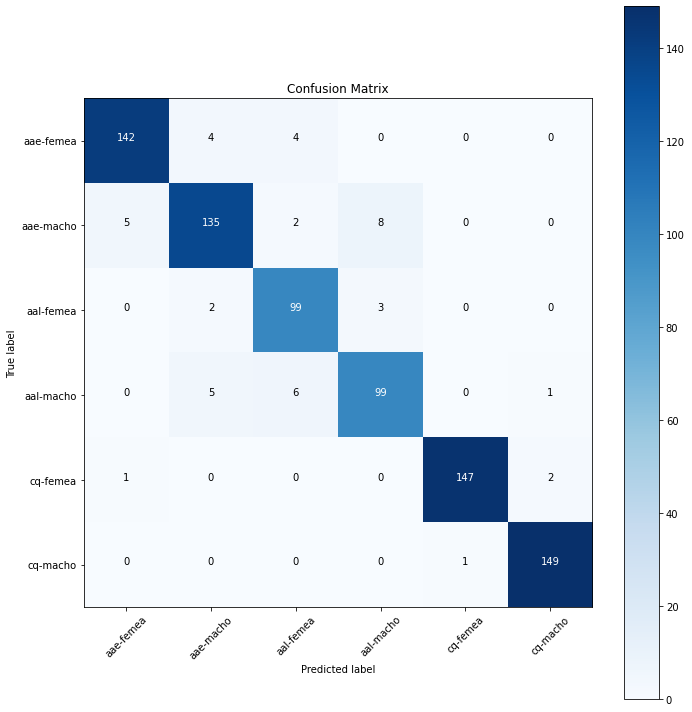

In [ ]:
cm = confusion_matrix(test_ds.classes,
                            y_pred,)

plot_confusion_matrix(cm, target_names, False, title='Confusion Matrix')

## Curva ROC

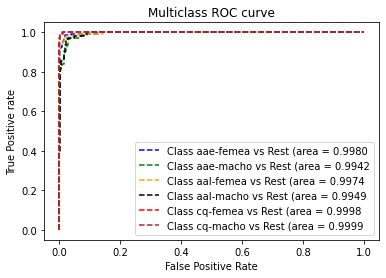

In [ ]:
#ROC CURVE
from sklearn.metrics import roc_curve, auc



# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = {}
n_class = 6
colors = ['blue','green','orange','black','red','brown']

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_ds.classes, predictions[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# plotting
for i in range(n_class):
  plt.plot(fpr[i], tpr[i], linestyle='--',color= colors[i], label=f'Class {target_names[i]} vs Rest (area = {roc_auc[i]:0.4f}')    
'''plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class aae-femea vs Rest (area = {1:0.4f}'.format(1, roc_auc[0]))
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class aae-macho vs Rest (area = {1:0.4f}'.format(1, roc_auc[1]))
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class aal-femea vs Rest (area = {1:0.4f}'.format(1, roc_auc[2]))
plt.plot(fpr[3], tpr[3], linestyle='--',color='black', label='Class aal-macho vs Rest (area = {1:0.4f}'.format(1, roc_auc[3]))
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Class cq-femea vs Rest (area = {1:0.4f}'.format(1, roc_auc[4]))
plt.plot(fpr[5], tpr[5], linestyle='--',color='brown', label='Class cq-macho vs Rest (area = {1:0.4f}'.format(1, roc_auc[5]))'''


plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

## Curva PR

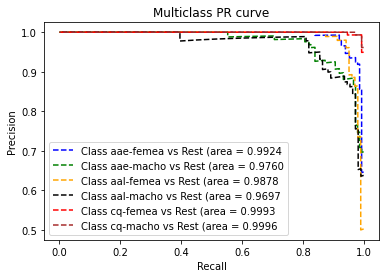

In [ ]:
#ROC CURVE
from sklearn.metrics import precision_recall_curve, auc



# roc curve for classes
precision = {}
recall = {}
thresh ={}
roc_auc = {}
n_class = 6
colors = ['blue','green','orange','black','red','brown']

for i in range(n_class):    
    precision[i], recall[i], thresh[i] = precision_recall_curve(test_ds.classes, predictions[:,i], pos_label=i)
    roc_auc[i] = auc(recall[i],precision[i])
    
# plotting
for i in range(n_class):
  plt.plot(recall[i],precision[i],  linestyle='--',color= colors[i], label=f'Class {target_names[i]} vs Rest (area = {roc_auc[i]:0.4f}')    
'''plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class aae-femea vs Rest (area = {1:0.4f}'.format(1, roc_auc[0]))
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class aae-macho vs Rest (area = {1:0.4f}'.format(1, roc_auc[1]))
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class aal-femea vs Rest (area = {1:0.4f}'.format(1, roc_auc[2]))
plt.plot(fpr[3], tpr[3], linestyle='--',color='black', label='Class aal-macho vs Rest (area = {1:0.4f}'.format(1, roc_auc[3]))
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label='Class cq-femea vs Rest (area = {1:0.4f}'.format(1, roc_auc[4]))
plt.plot(fpr[5], tpr[5], linestyle='--',color='brown', label='Class cq-macho vs Rest (area = {1:0.4f}'.format(1, roc_auc[5]))'''


plt.title('Multiclass PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.savefig('Multiclass PR',dpi=300);